<a href="https://colab.research.google.com/github/eogit/gy7709/blob/master/P08_zonalstats_with_cloudmask_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Sentinel-2 images and extracting time-series statistics

Workflow for the practical:
1. Search the ESA Copernicus Sentinel Data Hub for all available images over a region within a defined time period and low cloud cover
2. Download all selected images into a data directory
3. Convert all images into Geotiff files (retain only the 10 m resolution bands)
4. Save quicklooks of all images
5. Extract polygon statistics of the selected bands as a time series from all acquisition dates


The following code will ask you for authorisation to access Google Drive.

In [1]:
# BEFORE YOU RUN THIS BLOCK, EDIT THE VARIABLE wd BELOW TO POINT TO YOUR DIRECTORY ON GOOGLE DRIVE

# Load the Drive helper and mount your Google Drive as a drive in the virtual machine
from google.colab import drive
drive.mount('/content/drive')

# path to your Google Drive
# EDIT THIS LINE (/content/drive/My Drive is the top directory on Google Drive):
wd = "/content/drive/My Drive/practicals/p08"
print("Connected to data directory: " + wd)

# path to your temporary drive on the Colab Virtual Machine
cd = "/content/work"

# set plotting option for notebook
%matplotlib inline 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Connected to data directory: /content/drive/My Drive/practicals/p08


In [2]:
# import packages
from collections import OrderedDict
from copy import copy
import gdal
import json
import matplotlib.pyplot as plt
import numpy as np
import ogr
import os
from os import listdir
from os.path import isfile, isdir, join
import osr
import shutil
from skimage import exposure, io
from skimage.morphology import binary_erosion, binary_dilation
import subprocess
import sys
import zipfile

# install and import those packages not known to Colab by default
!pip install sentinelsat
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt

#gdal.UseExceptions()
#io.use_plugin('matplotlib')

Set up some directory names. 

Modify these to match your data directory structure.

In [3]:
# set up your directories for the satellite data
# Note that we do all the downloading and data analysis on the temporary drive
#    on Colab. We will copy the output directory to our Google Drive at the end.
#    Colab has more disk space (about 40 GB free space) than Google Drive (15 GB).

# directory for downloading the Sentinel-2 granules
downloaddir = join(cd, 'download') 
# directory for the image tiff files we will make
tiffdir = join(cd, 'tiff') 
# directory for the SCL tiff files we will make
scltiffdir = join(cd, 'tiffscl') 
# quicklook directory
quickdir = join(cd, 'quicklooks') 
# output directory for statistics file and search results
outdir = join(cd, 'outputs') 

# CAREFUL: This code removes the named directories and everything inside them to free up space
try:
  shutil.rmtree(downloaddir)
except:
  print(downloaddir + " not found.")

try:
  shutil.rmtree(tiffdir)
except:
  print(tiffdir + " not found.")

try:
  shutil.rmtree(scltiffdir)
except:
  print(scltiffdir + " not found.")

try:
  shutil.rmtree(quickdir)
except:
  print(quickdir + " not found.")

try:
  shutil.rmtree(outdir)
except:
  print(outdir + " not found.")

# create the new directories, unless they already exist
os.makedirs(cd, exist_ok=True)
print("Connected to temporary data directory: " + cd)
os.makedirs(downloaddir, exist_ok=True)
os.makedirs(tiffdir, exist_ok=True)
os.makedirs(quickdir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)

print("\nList of contents of " + wd)
for f in sorted(os.listdir(wd)):
  print(f)

/content/work/download not found.
/content/work/tiff not found.
/content/work/tiffscl not found.
/content/work/quicklooks not found.
/content/work/outputs not found.
Connected to temporary data directory: /content/work

List of contents of /content/drive/My Drive/practicals/p08
.ipynb_checkpoints
P08_zonalstats_with_cloudmask_colab.ipynb
field.dbf
field.prj
field.qpj
field.shp
field.shx
p8area.cpg
p8area.dbf
p8area.geojson
p8area.geojson.tmp
p8area.prj
p8area.qpj
p8area.shp
p8area.shx
p8area.zip
sencredentials-blank.txt
sencredentials.txt


Before proceeding, you have to make a text file called "sencredentials.txt" with your login details for the ESA Copernicus Sentinel Hub. The file has two lines of text.
Line 1: Your username
Line 2: Your password


In [0]:
# BEFORE YOU RUN THIS BLOCK, YOU NEED A USER ACCOUNT ON THE ESA SENTINEL HUB
# In a browser, go to https://scihub.copernicus.eu/dhus/#/home
# Click on the user symbol in the top right and then on 'sign up'
# Follow the instructions.
# When you have your account, create a .txt file in Word that contains two lines:
#   line 1 - your username
#   line 2 - your password
# save it under the name "sencredentials.txt"
# upload it to the same directory as the Jupyter Notebook on your Google Drive.
# This will allow the notebook to connect to your account on the ESA Data Archive.

# Download options and Data Hub search parameters
# EDIT THE OPTIONS BELOW TO CHANGE THE PROCESSING RUN:
ndown = 3 # number of scenes to be downloaded (in order of least cloud cover), should be less than 11 on Colab due to space
# YOU CAN PLACE A DIFFERENT SHAPEFILE ONTO YOUR GOOGLE DRIVE BUT MAKE SURE THAT
#    THE VARIABLE shapefile BELOW POINTS TO THE CORRECT FILE:
shapefile = join(wd, 'field.shp') # ESRI Shapefile of the study area
datefrom = '20190301' # start date for imagery search
dateto   = '20191231' # end date for imagery search
clouds = '[0 TO 10]' # range of acceptable cloud cover % for imagery search
    # Note that later versions of the Sentinelsat package require this in the format: clouds = (0, 10) 
credentials = join(wd, 'sencredentials.txt')  # contains two lines of text with username and password

# Filename options
# temporary VRT virtual raster stack of all image files
vrtfile = "mosaic_tmp_63782476532615387421.vrt"

Declare a function for converting all Sentinel-2 images in a directory into tiff files. Retain only the 10 m resolution bands.

In [0]:
# The next block of code is a function that reads in the Sentinel-2 L2A (Level 2A) image obtained 
#     from the Copernicus Sentinel Data Hub.
# It also changes the file to a new projection if defined
# Sentinel images can be obtained for free from this web site: 
#     https://scihub.copernicus.eu/dhus/#/home
# NOTE: The function deletes the original downloaded Sentinel-2 directory and all its contents
#     after processing it to TIFF format.

def s2tiff(indir, scldir, outdir, outscldir, ID, proj):
    '''
    indir = directory where the input band files are located - 
    scldir = directory where the input SCL cloud classification file is located
    outdir = directory where the image tiff file will be written if it does not already exist
    outscldir = directory where the SCL tiff file will be written if it does not already exist
    ID = a string giving the filename without file extension
    proj = output projection
    '''
    # list all files in input directory    
    print('Files in directory ' + indir)
    allfiles = sorted([f for f in listdir(indir) if isfile(join(indir, f))])
    for f in allfiles:
        print(f)

    # make a band selection
    print('Band files to be included in tiff file:')    
    bands = allfiles[1:5]
    for b in bands:
        print(b)

    # build a command line command for GDAL to convert the files into 10 m resolution VRT format
    vrtfile = join(outdir, ID + '_16Bit.vrt')
    cmd = ['gdalbuildvrt', '-resolution', 'user', '-tr' ,'10', '10', '-separate', vrtfile]
    for band in bands:
        cmd.append(join(indir, band))

    if not os.path.exists(vrtfile): # skip if the output file already exists
        print('\n')
        print(' '.join(cmd))
        print('\n')
        subprocess.run(cmd) # execute the command in the command line
    else:
        print(vrtfile,' already exists.\n')
    
    # check whether the output directory already exists and create it if not
    os.makedirs(outdir, exist_ok=True)
    os.makedirs(outscldir, exist_ok=True)

    # define output file names
    tiffile = join(outdir, ID + '_16Bit.tif')
    projtiffile = join(outdir, ID + '_16Bit_proj.tif')

    if not os.path.exists(projtiffile): # skip if the output file already exists
        # build a command to translate the four band raster files into one geotiff file with 4 bands
        cmd = ['gdal_translate', '-of' ,'GTiff', vrtfile, tiffile]
        print(' '.join(cmd))
        print('\n')
        # execute the GDAL command
        subprocess.run(cmd) 

        # build a command to reproject the single Geotiff image to a new projection
        cmd = ['gdalwarp', tiffile, projtiffile, '-t_srs', proj]
        print(' '.join(cmd))
        print('\n')
        # execute the GDAL command
        subprocess.run(cmd) 

        os.remove(vrtfile) # delete the vrt file
        os.remove(tiffile) # delete the tiffile in the old projection

    else:
        print(projtiffile,' already exists.\n')

    # build a command line command for GDAL to convert the SCL file into 10 m resolution VRT format
    vrtfile = join(outscldir, ID + '_SCL16Bit.vrt')
    cmd = ['gdalbuildvrt', '-resolution', 'user', '-tr' ,'10', '10', '-separate', vrtfile]
    # find SCL file
    allfiles = [f for f in listdir(scldir) if isfile(join(scldir, f))]
    sclfile = [f for f in allfiles if "SCL" in f.split("_")[2]]
    print(type(sclfile))
    for item in sclfile:
        print('SCL file: ' + item)
        cmd.append(join(scldir, item))
    
    if not os.path.exists(vrtfile): # skip if the output file already exists
        print('\n')
        print(' '.join(cmd))
        print('\n')
        subprocess.run(cmd) # execute the command in the command line
    else:
        print(vrtfile,' already exists.\n')
    
    # define output file names
    scltiffile = join(outscldir, ID + '_SCL16Bit.tif')
    projscltiffile = join(outscldir, ID + '_SCL16Bit_proj.tif')

    if not os.path.exists(projscltiffile): # skip if the output file already exists
        # build a command to translate the cloud mask band raster file into a geotiff file
        cmd = ['gdal_translate', '-of' ,'GTiff', vrtfile, scltiffile]
        print(' '.join(cmd))
        print('\n')
        # execute the GDAL command
        subprocess.run(cmd) 

        # build a command to reproject the Geotiff to a new projection
        cmd = ['gdalwarp', scltiffile, projscltiffile, '-t_srs', proj]
        print(' '.join(cmd))
        print('\n')
        # execute the GDAL command
        subprocess.run(cmd) 

        print("Created file: " + projscltiffile)
        os.remove(vrtfile) # delete the vrt file
        os.remove(scltiffile) # delete the tiffile in the old projection

    else:
        print(projscltiffile,' already exists.\n')

Declare a function for making one quicklook image in PNG format out of one or many TIFF files. The output file is smaller than the originals, i.e. not full resolution.


In [0]:
# This function makes one PNG quicklook file by mosaicking all tiff files in a list of filenames
# Note: the files must all the in the same projection

def quicklooks(tiffdir, infilelist, outdir, mosaicID, outsize):
    '''
    tiffdir = directory in which the files in infilelist are located
    infilelist = list of filenames (full path not included) to be processed
    outdir = directory where the PNG quicklook files will be saved
    mosaicID = beginning of the file name of the output files to be created (full path)
    outsize = percentage downscaling factor, e.g. 10 means 10% of xsize and 10% of ysize
    '''

    # make output filenames
    vrtfile = join(outdir, mosaicID + ".vrt")
    quicklookfile = join(outdir, mosaicID + ".png")

    print(vrtfile)
    print(quicklookfile)
    
    # save the list of file names to a text file for use in the GDAL command
    filelist = join(outdir, "filelist.txt") # make a file name
    
    print(filelist)

    file1 = open(filelist,"w") # open file in write mode 

    for f in infilelist:
        file1.write(join(tiffdir, f)) 
        file1.write("\n")
        print(join(tiffdir, f))
        print(os.path.exists(join(tiffdir, f)))
    file1.close() 

    # make a quicklook classification mosaic of all granules in PNG format using GDAL
    com = "gdalbuildvrt -overwrite -input_file_list " + filelist + " "+ vrtfile
    print(com)
    flag = os.system(com)
    if flag == 0:
        print('Created VRT file: ' + vrtfile)
    else:
        print('Error creating VRT file')

    # Create a PNG quicklook, scaled from 0 - 255
    com = "gdal_translate -of PNG -ot Byte -scale -outsize " + str(outsize) + "% " + \
        str(outsize) + "% " + vrtfile + " " + quicklookfile
    print(com)
    flag = os.system(com)
    if flag == 0:
        print('Created quicklook mosaic file: ' + quicklookfile)
    else:
        print('Error creating quicklook mosaic file')

Declare a function to read in the Sentinel 2 Level 2A product cloud mask and mask out cloudy pixels from the data.

In [0]:
def sentinel2_cloud_removal(imgfile, sclfile, outfile, maskfile, kernel_dil=(3, 3), kernel_ero=(7, 7), classes = [0, 1, 2, 3, 7, 8, 9, 10, 11]):
    """Motivated by the geospatial_learn package by Ciaran Robb. A further image erosion function
    is applied to reduce the area around clouds missed by the sen2cor algorithm.

    Removes clouds using the sen2cor scene classification. This is found in the .scl file of the L2A image folder.

    Sen2cor Scene Classification Legend:
    0 - NO_DATA (black)
    1 - SATURATED_OR_DEFECTIVE (red)
    2 - DARK_AREA_PIXELS (dark grey)
    3 - CLOUD_SHADOWS (brown)
    4 - VEGETATION (bright green)
    5 - BARE_SOILS (yellow)
    6 - WATER (blue)
    7 - CLOUD_LOW_PROBILITY (grey)
    8 - CLOUD_MEDIUM_PROBABILITY (light grey)
    9 - CLOUD_HIGH_PROBABILITY (white)
    10 - THIN_CIRRUS (light blue)
    11 - SNOW (pink)

    Based on this legend a reclassification will be carried out to generate a
    cloud & QC mask. The identified mask classes will become 0 and the others will become 1.

    imgfile: String indicating the input file name.
    sclfile: String pointing to the respective sen2cor scene classification (SCL).
    outfile: String containing the path and file name of the output file for the masked image
    maskfile: String containing the path and file name of the mask file
    kernel_dil: A tuple defining the dilation window applied to get rid of small cloud detections (often false classifications). Must be a pair of uneven numbers.
    kernel_ero: A tuple defining the erosion window applied to reduced cloud fringes. Must be a pair of uneven numbers.
    Returns nothing.
    """
    
    # split scl file paths
    path_scl_new, fn_new = os.path.split(sclfile)

    # split raster names
    name_new, fmt_new = fn_new.split(".", 2)

    # scl output names
    scl_rcl_new_out = join(path_scl_new, name_new + '_rcl.' + fmt_new)

    # read scl raster data and reclassify
    ds_new = gdal.Open(sclfile, gdal.GA_ReadOnly)
    bnd_new = ds_new.GetRasterBand(1)
    array_new = bnd_new.ReadAsArray()

    # recode the cloud mask to 0 (cloud and other masked areas) and 1 (good values)
    array_new[np.isin(array_new, classes)] = 0
    array_new[array_new != 0] = 1

    # erode cloudmask using skimage.morphology module
    #sieved_new = remove_small_objects(array_new, 10)
    dilated_new = binary_dilation(array_new, np.ones(kernel_dil, dtype=np.int))
    eroded_new = binary_erosion(dilated_new, np.ones(kernel_ero, dtype=np.int))

    # read image raster data and apply the mask to all bands
    img = gdal.Open(imgfile, gdal.GA_ReadOnly)
    print("Raster band count: ", img.RasterCount)
    
    # save the cloud mask raster layer to file
    print(maskfile)
    print(img.RasterXSize)
    print(img.RasterYSize)
    print(ds_new.RasterCount)

    output_raster = gdal.GetDriverByName('GTiff').Create(maskfile, img.RasterXSize, img.RasterYSize, ds_new.RasterCount, gdal.GDT_Int16) # Open the output file
    output_raster.SetGeoTransform(img.GetGeoTransform()) # use the same Geotransform and projection as for the input file
    output_raster.SetProjection(img.GetProjection())
    output_raster.GetRasterBand(1).WriteArray(eroded_new) # Write the mask layer to the Geotiff file
    output_raster.FlushCache()
    # Close raster files
    output_raster = None
    ds_new = None
    
    # create an empty numpy array filled with zeros to hold all masked bands
    img_masked = np.zeros((img.RasterCount, img.RasterYSize, img.RasterXSize)) # bands, rows, columns as in GDAL

    # iterate over all image bands to apply the mask
    for band in range(img.RasterCount):
        # the range function starts at 0 but GDAL starts numbering at 1
        print("Getting band ", band + 1)
        bnd_new = img.GetRasterBand(band + 1)
        bnd_array_new = bnd_new.ReadAsArray()
        # mask out clouds from band image and save to file
        img_masked[band,:,:] = np.where(eroded_new, bnd_array_new, 0) # apply the mask
        
    # Write raster dataset with all bands to a Geotiff file
    output_raster = gdal.GetDriverByName('GTiff').Create(outfile, img.RasterXSize, img.RasterYSize, img.RasterCount, \
                                                         gdal.GDT_Int16)  # Open the file
    output_raster.SetGeoTransform(img.GetGeoTransform()) # use the same Geotransform and projection as for the input file
    output_raster.SetProjection(img.GetProjection())
    for band in range(img.RasterCount):
        output_raster.GetRasterBand(band+1).WriteArray(img_masked[band,:,:]) # Write each masked image band to the Geotiff file
    output_raster.FlushCache()

    # Close raster files
    output_raster = None
    img = None

#######################################################################
# MAIN SCRIPT
#######################################################################

In [0]:
#######################################################################
# 1. Search the ESA Copernicus Sentinel Data Hub for all available images 
#    over a region within a defined time period and low cloud cover
#######################################################################

os.chdir(wd) # go to working directory

# load user credentials for Sentinel Data Hub at ESA, i.e. read two lines of text with username and password
with open(join(wd, credentials)) as f:
    lines = f.readlines()
username = lines[0].strip()
password = lines[1].strip()
f.close()

# Define the API
api = SentinelAPI(username, password, 'https://scihub.copernicus.eu/dhus')

Convert the shapefile into GeoJSON if not already done.

In [9]:
# convert the shapefile to geojson as required by the Sentinel Hub
gjfile = shapefile.split(".")[0]+".geojson"

# check whether it exists already, e.g. from a previous run, in that case skip this step
if not os.path.exists(gjfile):
    # check that shapefile exists
    if not os.path.exists(shapefile):
        print('Error: Shapefile not found: ' + shapefile)
    else:
        print('Shapefile found: ' + shapefile)
        # convert it
        com = "ogr2ogr -f GeoJSON -t_srs crs:84 \'" + gjfile + "\' \'" + shapefile + "\'"
        print(com)
        flag = os.system(com)
        if flag == 0:
            print('Shapefile converted to Geojson format: ' + gjfile)
        else:
            print('Error converting shapefile to Geojson')
else:
    print('Geojson file already exists: ' + gjfile)

# NOTE: The search is limited by the length of the search string, as explained below:
#   <geographic type>=POLYGON((P1Lon P1Lat, P2Lon P2Lat, …, PnLon PnLat, P1Lon P1Lat))
#   where P1Lon and P1Lat are the Longitude and Latitude coordinates of the first point 
#   of the polygon in decimal degrees (DDD) format (e.g. 2.17403, 41.40338) and so on.
#   The coordinates of the last point of the polygon must coincide with the coordinates 
#   of the first point of the polygon.
#   There is not a fixed limit for the maximum number of points to be used to define 
#   the Area of Interest (AOI). The limit is related to the maximum number of characters 
#   for the GUI search (i.e 8000). The maximum footprint extent possible is defined by 
#   the Mercator projection used on DHuS, i.e. LAT [-180, + 180] and LONG [-85.05, +85.05].

# To prevent errors due to the length of the search string, we want to use the bounding
#    box coordinates of the polygon layer for the image search.
# get the bounding box of the geojson layer as a closed polygon in wkt format
def bbox(coord_list):
     box = []
     for i in (0,1):
         res = sorted(coord_list, key=lambda x:x[i])
         box.append((res[0][i],res[-1][i]))
     ret = "POLYGON(" + f"({box[0][0]}  {box[1][0]}, {box[0][1]} {box[1][0]}, {box[0][1]} {box[1][1]}, {box[0][0]} {box[1][1]}, {box[0][0]}  {box[1][0]}))"
     return ret

extent = bbox(list(geojson.utils.coords(read_geojson(gjfile))))

# convert the geojson to wkt for the API search on the Sentinel Hub
footprint = geojson_to_wkt(read_geojson(gjfile))
print("Footprint from the Geojson file:")
print(footprint)
print("Footprint from the bounding box of the Geojson file used in image search:")
print(extent)


# get projection information from the shapefile to serve as output projection for the mosaic
driver = ogr.GetDriverByName('ESRI Shapefile')
shp = driver.Open(shapefile)
layer = shp.GetLayer()
outSpatialRef = layer.GetSpatialRef().ExportToWkt()
shp = None # close file

Shapefile found: /content/drive/My Drive/practicals/p08/field.shp
ogr2ogr -f GeoJSON -t_srs crs:84 '/content/drive/My Drive/practicals/p08/field.geojson' '/content/drive/My Drive/practicals/p08/field.shp'
Shapefile converted to Geojson format: /content/drive/My Drive/practicals/p08/field.geojson


Search the ESA Sentinel data hub.

In [0]:
# set query parameters and search the Sentinel data hub
query_kwargs = {
        'area': extent,
        'date': (datefrom, dateto),
        'platformname': 'Sentinel-2',
        'processinglevel': 'Level-2A',
        'cloudcoverpercentage': clouds
        }

# search the Sentinel data hub API
products = api.query(**query_kwargs)

In [11]:
# convert list of products to Pandas DataFrame
products_df = api.to_dataframe(products)
print('Search resulted in '+str(products_df.shape[0])+' satellite images with '+
      str(products_df.shape[1])+' attributes.')

os.chdir(outdir) # set working direcory to directory for our text file outputs

# sort the search results
products_df_sorted = products_df.sort_values(['cloudcoverpercentage', 'ingestiondate'], ascending=[True, True])
#print(products_df_sorted)
outfile = 'searchresults_full.csv'
products_df_sorted.to_csv(outfile)
print("Search results saved: " + outfile)

# limit to first Ndown products sorted by lowest cloud cover and earliest acquisition date
products_df_n = products_df_sorted.head(ndown)
outfile = 'searchresults4download.csv'
products_df_n.to_csv(outfile)
print("Download list saved: " + outfile)

# get the footprints of the selected scenes
s2footprints = products_df_n.footprint
outfile = 'searchresultsfootprints.csv'
s2footprints.to_csv(outfile, header = False)
print("Granule footprints saved: " + outfile)

Search resulted in 10 satellite images with 36 attributes.
Search results saved: searchresults_full.csv
Download list saved: searchresults4download.csv
Granule footprints saved: searchresultsfootprints.csv


Download data. This takes a long time if many images are selected.

In [12]:
#######################################################################
# 2. Download all selected images into a data directory
#######################################################################

os.chdir(downloaddir) # set working direcory to download directory

# download sorted and reduced products in order
api.download_all(products_df_n['uuid'])

Downloading: 100%|██████████| 1.19G/1.19G [01:43<00:00, 11.5MB/s]
MD5 checksumming: 100%|██████████| 1.19G/1.19G [00:02<00:00, 471MB/s]
Downloading: 100%|██████████| 810M/810M [01:10<00:00, 11.6MB/s]
MD5 checksumming: 100%|██████████| 810M/810M [00:01<00:00, 458MB/s]
Downloading: 100%|██████████| 818M/818M [01:10<00:00, 11.5MB/s]
MD5 checksumming: 100%|██████████| 818M/818M [00:01<00:00, 471MB/s]


(OrderedDict([('7a8fd8e8-cdfc-46f5-907a-21c0b1ac0a7f',
               {'Creation Date': datetime.datetime(2019, 9, 19, 23, 20, 20, 975000),
                'Ingestion Date': datetime.datetime(2019, 9, 19, 23, 19, 37, 691000),
                'Online': True,
                'date': datetime.datetime(2019, 9, 19, 11, 7, 21, 24000),
                'downloaded_bytes': 1190327688,
                'footprint': 'POLYGON((-1.5015259 53.24020834947074,0.141769904481162 53.20820137275637,0.071678487044592 52.22256603361336,-1.5350342 52.25345680664421,-1.5015259 53.24020834947074))',
                'id': '7a8fd8e8-cdfc-46f5-907a-21c0b1ac0a7f',
                'md5': '21886E4A826F8627B2F8653206E16CA3',
                'path': './S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654.zip',
                'size': 1190327688,
                'title': 'S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654',
                'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('7

In [13]:
# save the footprints of the scenes marked for download together with their metadata in a Geojson file
# first, run a new query to get the metadata for the selected scenes
products_n = OrderedDict()
for uuid in products_df_n['uuid']:
    kw = query_kwargs.copy()
    kw['uuid'] = uuid
    pp = api.query(**kw)
    products_n.update(pp)

# then, write the footprints and metadata to a geojson file
outfile = join(outdir, 'footprints.geojson')
with open(outfile, 'w') as f:
    json.dump(api.to_geojson(products_n), f)
print("Granule footprints saved as GeoJson: " + outfile)

Granule footprints saved as GeoJson: /content/work/outputs/footprints.geojson


In [14]:
#######################################################################
# 3. Convert all images into reprojected Geotiff files.
#    Retain only the 10 m resolution bands and apply cloud mask.
#######################################################################
    
# set working direcory to download directory
os.chdir(downloaddir)

# get list of all zip files in the data directory
allfiles = [f for f in listdir(downloaddir) if isfile(join(downloaddir, f))]

# unzip all these files and convert the 10 m bands to Geotiff
for x in range(len(allfiles)):

  if allfiles[x].split(".")[1] == "zip":
    print("Unzipping file ", x+1, ": ", allfiles[x])

    with zipfile.ZipFile(allfiles[x], "r") as zipf:
      # first extract the files
      zipf.extractall(downloaddir)

      # then remove the zip file to save disk space
      os.remove(join(downloaddir, allfiles[x]))

      # in this directory are the Sentinel-2, 10 m resolution band files.
      # extract *.SAFE subdirectory path, then GRANULE, then L2A_*, then IMG_DATA, then R10m
      sceneID = allfiles[x].split(".")[0] # the first part of the directory name is the granule ID

      # find *.SAFE subdirectory
      dirlist = [d for d in listdir(downloaddir) if isdir(join(downloaddir, d))]
      for y in range(len(dirlist)):
        if dirlist[y].split(".")[1] == "SAFE":
          s2rootdir = join(downloaddir, dirlist[y])

      # find GRANULE subdirectory
      thisdir = join(s2rootdir, "GRANULE")

      # find L2A_* subdirectory
      dirlist = [d for d in listdir(thisdir) if isdir(join(thisdir, d))]
      for y in range(len(dirlist)):
        if dirlist[y].split("_")[0] == "L2A":
          thisdir = join(thisdir, dirlist[y])

      # find IMG_DATA subdirectory
      thisdir = join(thisdir, "IMG_DATA")
      scldir = copy(thisdir) # also find the path to the 20 m resolution SCL file with cloud mask information

      # find R10m subdirectory
      thisdir = join(thisdir, "R10m")

      # find R20m subdirectory for SCL file
      scldir = join(scldir, "R20m")
      
      # call our function to convert the granule into a reprojected Geotiff file
      s2tiff(thisdir, scldir, tiffdir, scltiffdir, sceneID, outSpatialRef)

      # apply the cloud masking procedure
      imgfile = join(tiffdir, sceneID + '_16Bit_proj.tif')
      sclfile = join(scltiffdir, sceneID + '_SCL16Bit_proj.tif')

      # define the output file names
      outfile = join(outdir, sceneID + '_clmasked.tif') # for the cloud masked image bands
      maskfile = join(outdir, sceneID + '_clmask.tif') # for the cloud mask itself
      sentinel2_cloud_removal(imgfile, sclfile, outfile, maskfile, kernel_dil=(5, 5), kernel_ero=(15, 15), classes = [0, 1, 2, 3, 6, 8, 9, 10, 11])

      # finally, delete the unzipped Sentinel-2 image directory and its contents
      #    to free up disk space
      shutil.rmtree(s2rootdir)

Unzipping file  1 :  S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654.zip
Files in directory /content/work/download/S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654.SAFE/GRANULE/L2A_T30UXD_A022156_20190919T111421/IMG_DATA/R10m
T30UXD_20190919T110721_AOT_10m.jp2
T30UXD_20190919T110721_B02_10m.jp2
T30UXD_20190919T110721_B03_10m.jp2
T30UXD_20190919T110721_B04_10m.jp2
T30UXD_20190919T110721_B08_10m.jp2
T30UXD_20190919T110721_TCI_10m.jp2
T30UXD_20190919T110721_WVP_10m.jp2
Band files to be included in tiff file:
T30UXD_20190919T110721_B02_10m.jp2
T30UXD_20190919T110721_B03_10m.jp2
T30UXD_20190919T110721_B04_10m.jp2
T30UXD_20190919T110721_B08_10m.jp2


gdalbuildvrt -resolution user -tr 10 10 -separate /content/work/tiff/S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654_16Bit.vrt /content/work/download/S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654.SAFE/GRANULE/L2A_T30UXD_A022156_20190919T111421/IMG_DATA/R10m/T30UXD_20190919T110721_B02_10m.jp2 /

In [15]:
#######################################################################
# 4. Save quicklooks of all image mosaics for each image acquisition date
#######################################################################

# declare a function to eliminate duplicate entries in a list by converting to a dictionary and back
def remove_duplicates(x):
    return list(dict.fromkeys(x))

# get list of all tiff files in the data directory
allfiles = [f for f in listdir(tiffdir) if (isfile(join(tiffdir, f)) and f.endswith('.tif'))]

print("\nAll files:")
print(allfiles)

# pull out all acquisition dates from the file names
# for the Sentinel-2 naming convention, see 
#     https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention
acqdates = remove_duplicates([f.split("_")[2].split("T")[0] for f in allfiles])

print("\nAll acquisition dates (sorted):")
print([f for f in sorted(acqdates)])

# go through all dates
for d in acqdates:
    
    # pull out all file names of the same acquisition date
    files2mosaic = [f for f in allfiles if (f.split("_")[2].split("T")[0] == d)]

    print("\nImages taken on date " + d)
    print(files2mosaic)
    
    # define a filename for the output file
    mosaicID = "S2_" + d

    # call our function
    quicklooks(tiffdir, files2mosaic, quickdir, mosaicID, 10)


All files:
['S2B_MSIL2A_20191027T112119_N0213_R037_T30UXD_20191027T122034_16Bit_proj.tif', 'S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif', 'S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654_16Bit_proj.tif']

All acquisition dates (sorted):
['20190629', '20190919', '20191027']

Images taken on date 20191027
['S2B_MSIL2A_20191027T112119_N0213_R037_T30UXD_20191027T122034_16Bit_proj.tif']
/content/work/quicklooks/S2_20191027.vrt
/content/work/quicklooks/S2_20191027.png
/content/work/quicklooks/filelist.txt
/content/work/tiff/S2B_MSIL2A_20191027T112119_N0213_R037_T30UXD_20191027T122034_16Bit_proj.tif
True
gdalbuildvrt -overwrite -input_file_list /content/work/quicklooks/filelist.txt /content/work/quicklooks/S2_20191027.vrt
Created VRT file: /content/work/quicklooks/S2_20191027.vrt
gdal_translate -of PNG -ot Byte -scale -outsize 10% 10% /content/work/quicklooks/S2_20191027.vrt /content/work/quicklooks/S2_20191027.png
Created quicklook mosaic file: /

Below, we define the main functions, including one to extract zonal statistics from the polygons in the shapefile for all 10 m resolution bands of an image, and another one to loop over the entire time series.

In [0]:
#######################################################################
# 5. Extract polygon statistics as a time series from all data
#######################################################################

def tif2raster(tiffile):
    # read in a geotiff file (unsigned 16-bit integer format) and turn into a Python raster object
    img_ds = io.imread(tiffile)
    # convert to 16bit numpy array 
    img = np.array(img_ds, dtype='int16')
    return(img)

def zonal_stats(feat, input_zone_polygon, input_tiff, verbose = False, graphics = True, bands=[1,2,3]):
    '''
        extracts statistics from a feature (polygon) of a shapefile from a tiff file with several bands
        heavily adapted from:
        https://gis.stackexchange.com/questions/208441/zonal-statistics-of-a-polygon-and-assigning-mean-value-to-the-polygon
    '''

    if verbose:
        print("--------------------------------------------------------------------")
        print("Processing raster file: " + input_tiff)
        
    # Open vector data
    shp = ogr.Open(input_zone_polygon)
    lyr = shp.GetLayer()

    # Get raster georeference info
    dataset = gdal.Open(input_tiff, gdal.GA_ReadOnly)
    if not dataset:
        print("Error. Tiff file not found: " + input_tiff)

    ncols = dataset.RasterXSize
    nrows = dataset.RasterYSize
    nbands = dataset.RasterCount
    wkt_projection = dataset.GetProjection()

    if verbose:
        print("Raster size: {} x {} x {}".format(ncols, nrows, nbands))
        print("Raster projection: {}".format(wkt_projection))

    geotransform = dataset.GetGeoTransform()
    if geotransform:
        xOrigin = geotransform[0]
        yOrigin = geotransform[3]
        pixelWidth = geotransform[1]
        pixelHeight = geotransform[5]
        if verbose:
            print("Tiff file image origin xmin,yax = ({}, {})".format(geotransform[0], geotransform[3]))
            print("Pixel Size x,y = ({}, {})".format(geotransform[1], geotransform[5]))
    else:
        print("Error. Geotransform not found in tiff file: " + input_tiff) 

    # Reproject vector geometry to same projection as raster
    sourceSR = lyr.GetSpatialRef()
    targetSR = osr.SpatialReference()
    targetSR.ImportFromWkt(wkt_projection)
    coordTrans = osr.CoordinateTransformation(sourceSR,targetSR)
    feat = lyr.GetNextFeature()
    geom = feat.GetGeometryRef()
    geom.Transform(coordTrans)

    # Get extent of the feature for which to extract the raster statistics
    geom = feat.GetGeometryRef()
    if (geom.GetGeometryName() == 'MULTIPOLYGON'):
        count = 0
        pointsX = []; pointsY = []
        for polygon in geom:
            geomInner = geom.GetGeometryRef(count)
            ring = geomInner.GetGeometryRef(0)
            numpoints = ring.GetPointCount()
            for p in range(numpoints):
                    lon, lat, z = ring.GetPoint(p)
                    pointsX.append(lon)
                    pointsY.append(lat)
            count += 1
    elif (geom.GetGeometryName() == 'POLYGON'):
        ring = geom.GetGeometryRef(0)
        numpoints = ring.GetPointCount()
        pointsX = []; pointsY = []
        for p in range(numpoints):
                lon, lat, z = ring.GetPoint(p)
                pointsX.append(lon)
                pointsY.append(lat)

    else:
        sys.exit("ERROR: Geometry needs to be either Polygon or Multipolygon")

    # extent of this feature in map coordinates
    xmin = min(pointsX)
    xmax = max(pointsX)
    ymin = min(pointsY)
    ymax = max(pointsY)

    if verbose:
        print("\nFeature extent in map coordinates: xmin,xmax, ymin, ymax", xmin, xmax, ymin, ymax)
       
    # raster layer extent in map coordinates
    xmin1 = xOrigin
    xmax1 = xOrigin + ncols * pixelWidth
    ymin1 = yOrigin + nrows * pixelHeight
    ymax1 = yOrigin

    if verbose:
        print("\nGeotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1")
        print(xmin1,xmax1,ymin1,ymax1)
    
    # extent of the intersect between the featurs / polygon / zone and the raster image in map coordinates
    xmin2 = max(xmin,xmin1)
    xmax2 = min(xmax,xmax1)
    ymin2 = max(ymin,ymin1)
    ymax2 = min(ymax,ymax1)

    if verbose:
        print("\nIntersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2")
        print(xmin2,xmax2,ymin2,ymax2)
    
    # clip the Geotiff raster layer to the extent of the intersect with the feature
    xoff = int((xmin2 - xOrigin)/pixelWidth)
    yoff = int((yOrigin - ymax2)/pixelWidth)
    xcount = int((xmax2 - xmin2)/pixelWidth)
    ycount = int((ymax2 - ymin2)/pixelWidth)

    if verbose:
        print("\nclipped raster layer extent in pixels: xoff, yoff, xcount, ycount")
        print("xoff = ", xoff)
        print("yoff = ", yoff)
        print("xcount = ", xcount)
        print("ycount = ", ycount)

    # clip the rasterised feature layer to the extent of the intersect with the feature
    xoff1 = int((xmin2 - xmin)/pixelWidth)
    yoff1 = int((ymax - ymax2)/pixelWidth)
    xcount1 = int((xmax2 - xmin2)/pixelWidth)
    ycount1 = int((ymax2 - ymin2)/pixelWidth)

    if verbose:
        print("\nclipped feature layer extent in pixels: xoff1,yoff1,xcount1,ycount1")
        print("xoff1 = ", xoff1)
        print("yoff1 = ", yoff1)
        print("xcount1 = ", xcount1)
        print("ycount1 = ", ycount1)

    # Create memory target raster for the mask with all pixels within the feature (zone)
    target_ds = gdal.GetDriverByName('MEM').Create('', xcount, ycount, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform((xmin2, pixelWidth, 0, ymax2, 0, pixelHeight,))

    # make projection the same as for the Geotiff Sentinel-2 raster file
    target_ds.SetProjection(wkt_projection)

    # create an empty array to hold the statistics results for all bands
    stats = np.zeros((nbands, 7))

    # plot a colour composite of three bands
    if graphics:
        # create an empty array to hold the 3 stretched colour bands
        img = np.zeros((ycount, xcount, 3), dtype = np.int16)
        for band in range(0, 3):
            # Read intersecting Geotiff raster layer values as an array
            
            ################## TODO ######################
            # memory error here if image is very large
            # downsample the image if too big

            print("  Band:", bands[band])
            thisband = np.array(dataset.GetRasterBand(bands[band]).ReadAsArray(xoff, yoff, xcount, ycount)).astype(np.int16)
            print("    min, max of this band ", np.min(thisband), np.max(thisband))
            # Histogram equalisation stretching
            img[:, :, band] = np.int16(256 * exposure.equalize_hist(thisband, nbins=256, mask=None))
            print("    min, max of the stretched band ", np.min(img[:, :, band]), np.max(img[:, :, band]))
            # Contrast stretching and byte scaling
            # p2, p98 = np.percentile(thisband, (2, 98))
            # img[:, :, band] = np.int16(exposure.rescale_intensity(thisband, in_range=(p2, p98)) * 255)
        plt.figure().suptitle("Colour composite")
        io.imshow(img)
        io.show()
        img = None # free up memory
        thisband = None

    # Rasterize the feature (zone polygon) to the target raster layer
    #   burn_value of 1 indicates that a pixels is inside the feature (zone)
    gdal.RasterizeLayer(target_ds, [1], lyr, burn_values=[1]) #, options = ['ALL_TOUCHED=True'])

    if verbose:
        zonesize = target_ds.GetRasterBand(1).ReadAsArray().shape
        print("Zone mask raster size: ", zonesize[0], zonesize[1], " Number of pixels: ", zonesize[0] * zonesize[1])
        print("Zone mask raster min,max: ", np.nanmin(target_ds.GetRasterBand(1).ReadAsArray()), np.nanmax(target_ds.GetRasterBand(1).ReadAsArray()))

    if graphics:
        # Display the whole rasterised zone mask
        plt.figure().suptitle("Zone mask")
        io.imshow(np.array(target_ds.GetRasterBand(1).ReadAsArray()), cmap='gray_r')

    # loop over all bands
    for band in range(1, nbands + 1):
        
        if verbose:
            print("\nBand ", band)

        # Read intersecting Geotiff raster layer values as an array
        dataraster = np.array(dataset.GetRasterBand(band).ReadAsArray(xoff, yoff, xcount, ycount)).astype(np.float)

        # clip the rasterised feature layer to the extent of the intersect with the geotiff raster layer
        datamask = target_ds.GetRasterBand(1).ReadAsArray().astype(np.byte)

        # do something here to catch situations where dataraster is all NaNs
        #    replace 1 in datamask with 0 where NaNs are found in dataraster
        datamask[np.isnan(dataraster)] = 0
        #    replace 1 in datamask with 0 where 0 values are found in dataraster (i.e. cloud masked)
        datamask = np.where(dataraster == 0, 0, datamask)

        warnme = 0 # no warnings so far

        if (np.nanmin(dataraster) == np.nan and np.nanmax(dataraster) == np.nan):
            print("WARNING: All dataraster values are NaN.")
            warnme = warnme + 1
        else:
            if (dataraster.shape == ()):
                print("WARNING: Failed to create dataraster.")
                warnme = warnme + 1
            else:
                if verbose:
                    print("Data raster min, max: ", np.nanmin(dataraster), np.nanmax(dataraster))
                            
                if (np.min(datamask) == 0 and np.max(datamask) == 0):
                    print("WARNING: All datamask values are zero.")
                    warnme = warnme + 1
                else:
                    if verbose:
                        print("Data mask min, max: ", np.min(datamask), np.max(datamask))
                    
                    # Apply the mask from the rasterised feature layer (zone polygon) to the Geotiff raster
                    # at this point, we need to invert the mask (swap 0 and 1) because masked arrays treat values of 1 as being masked out
                    # the stats are calculated under the mask where it is 0. Hence the logical_not below.
                    zoneraster = np.ma.MaskedArray(dataraster, np.logical_not(datamask))
                    dataraster = None # free up memory
                    datamask = None
                    
                    if (np.min(zoneraster.data) == 1 and np.max(zoneraster.data) == 1):
                        print("WARNING: All zoneraster values are masked out.")
                        warnme = warnme + 1
                    else:
                        if verbose:
                            print("Zone raster min, max: ", np.ma.min(zoneraster), np.ma.max(zoneraster))
                            print("  Number of pixels not under the mask (good values) : ", np.ma.count(zoneraster))
                            print("  Number of pixels under the mask (ignored in stats): ", np.ma.count_masked(zoneraster))
                            print("  Total number of pixels: ", np.ma.count_masked(zoneraster) + np.ma.count(zoneraster))
                            
                        if graphics:
                            # histogram equalisation of the masked raster array
                            img = np.int16(256 * exposure.equalize_hist(zoneraster.filled(0), nbins=256, mask = np.logical_not(zoneraster.mask)))
                            # Contrast stretching
                            #p2, p98 = np.percentile(zoneraster, (2, 98))
                            #img = exposure.rescale_intensity(zoneraster, in_range=(p2, p98))
                            plt.figure().suptitle("Zone raster")
                            io.imshow(img, cmap='gray_r')

        if graphics:
            io.show()

        # calculate band statistics under the zone mask
        # N.B. The -1 is there to get Python indices from 0...3 from the band variable 1...4 (see for loop)
        # Exclude zero values from the stats, as these are missing values or cloud masked pixels
        stats[band - 1, 0] = band
        stats[band - 1, 1] = np.ma.count(zoneraster)
        stats[band - 1, 2] = np.ma.mean(zoneraster)
        stats[band - 1, 3] = np.ma.median(zoneraster)
        stats[band - 1, 4] = np.ma.std(zoneraster)
        stats[band - 1, 5] = np.ma.var(zoneraster)
        stats[band - 1, 6] = np.ma.sum(zoneraster)       
        
    # close files
    dataset = None
    shp = None
    
    # free up memory
    target_ds = None

    if (warnme > 0):
        print(warnme, " WARNINGS issued. Returning zero values from the zone statistics function.")

    return stats


def loop_zonal_stats(input_zone_polygon, input_tiff, verbose = False, graphics = False, bands = [1,2,3]):

    shp = ogr.Open(input_zone_polygon)
    lyr = shp.GetLayer()
    featList = range(lyr.GetFeatureCount())
    statDict = {}

    for FID in featList:
        if verbose:
            print("Feature ID: ", FID)
        feat = lyr.GetFeature(FID)
        meanValue = zonal_stats(feat, input_zone_polygon, input_tiff, verbose, graphics)
        statDict[FID] = meanValue
    return statDict

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



All tile IDs (sorted):
T30UXD



Image files acquired for tile T30UXD
S2B_MSIL2A_20191027T112119_N0213_R037_T30UXD_20191027T122034_16Bit_proj.tif
S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif
S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654_16Bit_proj.tif

Acquisition dates for this tile (sorted):
['20190629', '20190919', '20191027']

Saving tile statistics to file:  /content/work/outputs/S2_T30UXD.txt
Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /content/work/tiff/S2B_MSIL2A_20191027T112119_N0213_R037_T30UXD_20191027T122034_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.535019632844517, 53.24020834899015)
Pixel Size x,y = (

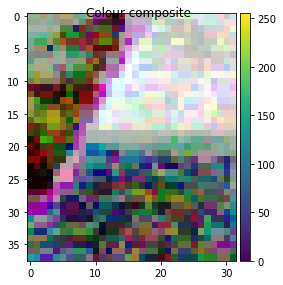

Zone mask raster size:  38 32  Number of pixels:  1216
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  155.0 403.0
Data mask min, max:  0 1
Zone raster min, max:  163.0 403.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


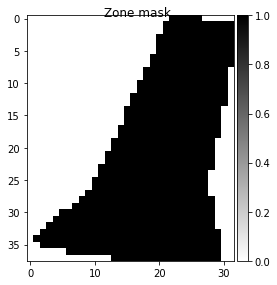

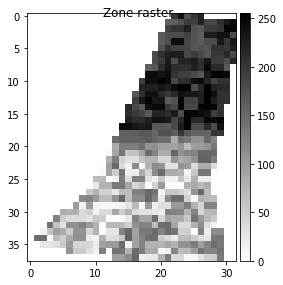


Band  2
Data raster min, max:  430.0 800.0
Data mask min, max:  0 1
Zone raster min, max:  512.0 790.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


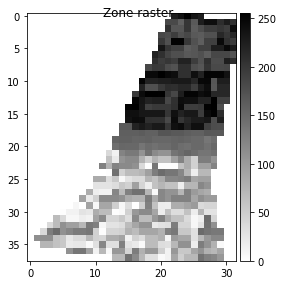


Band  3
Data raster min, max:  179.0 502.0
Data mask min, max:  0 1
Zone raster min, max:  221.0 472.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


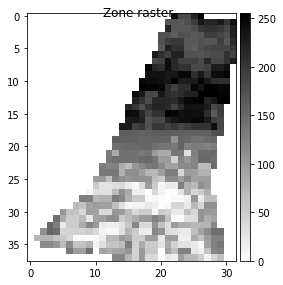


Band  4
Data raster min, max:  2728.0 4872.0
Data mask min, max:  0 1
Zone raster min, max:  3842.0 4536.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


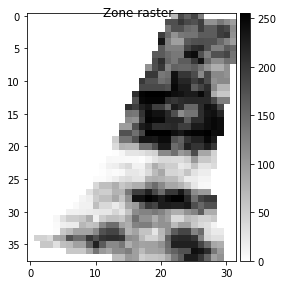

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /content/work/tiff/S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.535019632844517, 53.24020834899015)
Pixel Size x,y = (0.00012066297065282597, -0.00012066297065282597)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -0.899700981243248 -0.8957247861807945 52.787888834659604 52.79249049860829

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.535019632844517 0.14171300734715264 52.22253685450422 53.24020834899015

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-0.899700981243248 -0.8957247861807945 52.78788883465960

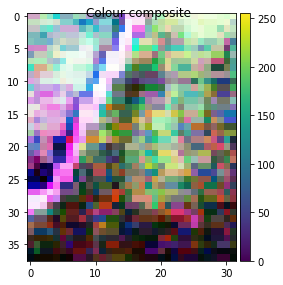

Zone mask raster size:  38 32  Number of pixels:  1216
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  176.0 479.0
Data mask min, max:  0 1
Zone raster min, max:  193.0 317.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


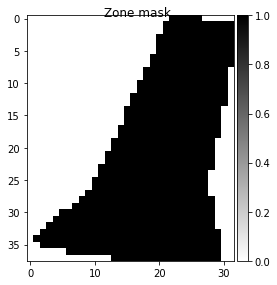

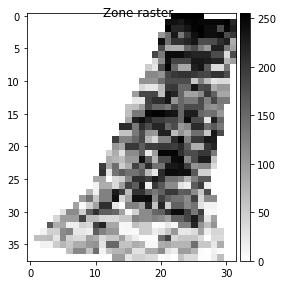


Band  2
Data raster min, max:  532.0 768.0
Data mask min, max:  0 1
Zone raster min, max:  549.0 758.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


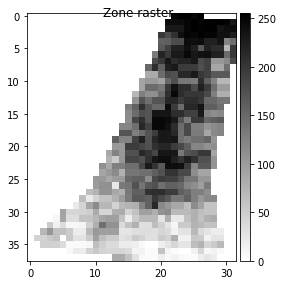


Band  3
Data raster min, max:  181.0 531.0
Data mask min, max:  0 1
Zone raster min, max:  196.0 280.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


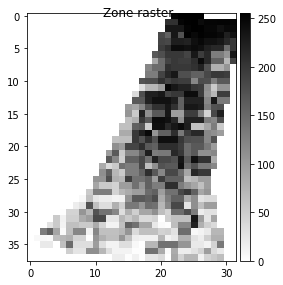


Band  4
Data raster min, max:  3702.0 6600.0
Data mask min, max:  0 1
Zone raster min, max:  5776.0 6592.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


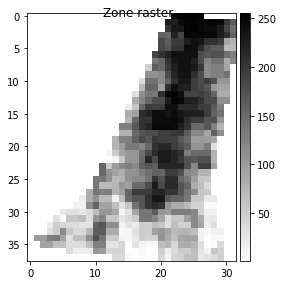

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature ID:  0
--------------------------------------------------------------------
Processing raster file: /content/work/tiff/S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654_16Bit_proj.tif
Raster size: 13896 x 8434 x 4
Raster projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Tiff file image origin xmin,yax = (-1.535019632844517, 53.24020834899015)
Pixel Size x,y = (0.00012066297065282597, -0.00012066297065282597)

Feature extent in map coordinates: xmin,xmax, ymin, ymax -0.899700981243248 -0.8957247861807945 52.787888834659604 52.79249049860829

Geotiff raster extent in map coordinates: xmin1, xmax1, ymin1, ymax1
-1.535019632844517 0.14171300734715264 52.22253685450422 53.24020834899015

Intersect extent in map coordinates: xmin2, xmax2, ymin2, ymax2
-0.899700981243248 -0.8957247861807945 52.78788883465960

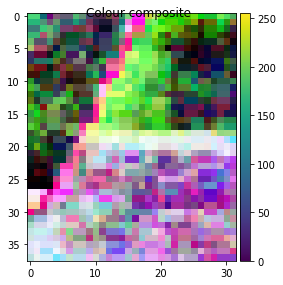

Zone mask raster size:  38 32  Number of pixels:  1216
Zone mask raster min,max:  0 1

Band  1
Data raster min, max:  303.0 521.0
Data mask min, max:  0 1
Zone raster min, max:  303.0 439.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


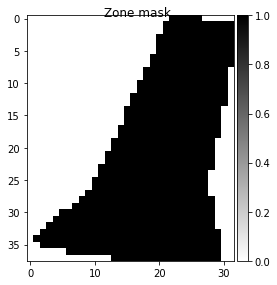

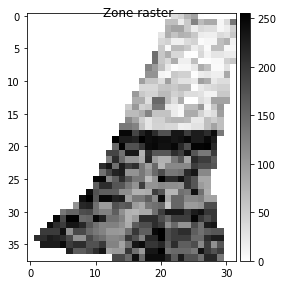


Band  2
Data raster min, max:  569.0 874.0
Data mask min, max:  0 1
Zone raster min, max:  678.0 874.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


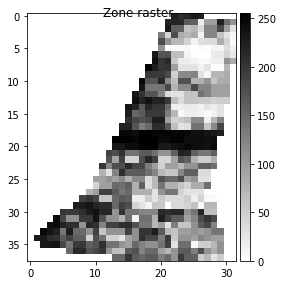


Band  3
Data raster min, max:  355.0 719.0
Data mask min, max:  0 1
Zone raster min, max:  365.0 634.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


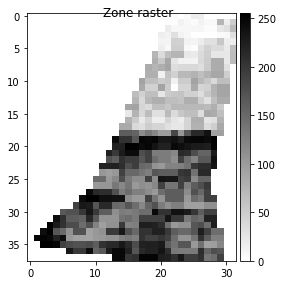


Band  4
Data raster min, max:  3071.0 5249.0
Data mask min, max:  0 1
Zone raster min, max:  3350.0 5053.0
  Number of pixels not under the mask (good values) :  650
  Number of pixels under the mask (ignored in stats):  566
  Total number of pixels:  1216


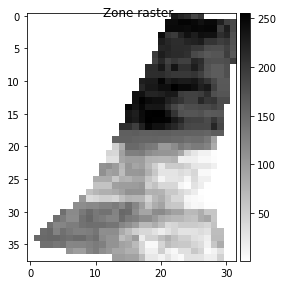

In [17]:
# pull out all tile IDs from the file names
# the tiling grid can be downloaded from here as a .kml file:
#     https://sentinel.esa.int/web/sentinel/missions/sentinel-2/data-products
tiles = sorted(remove_duplicates([f.split("_")[5] for f in allfiles]))

print("\nAll tile IDs (sorted):")
for t in tiles:
    print(t)
print("\n") # new line

# check whether shapefile exists
if not os.path.exists(shapefile):
    print('Shapefile not found: ' + shapefile)
else:
    # go through all tiles and extract statistics for all available acquisition dates for that tile
    
    for t in tiles:

        # get all file names with the same tile ID from the list of all tiff files
        filestack = [f for f in allfiles if (f.split("_")[5] == t)]
        print("\nImage files acquired for tile " + t)
        for xfile in filestack:
            print(xfile)

        # pull out all acquisition dates from the file names
        acqdates = remove_duplicates([f.split("_")[2].split("T")[0] for f in filestack])
        print("\nAcquisition dates for this tile (sorted):")
        print([f for f in sorted(acqdates)])
        
        # define a filename for the output text file with the statistics
        timeseries = join(outdir, "S2_" + t + ".txt")
        print("\nSaving tile statistics to file: ", timeseries)
        outfile = open(timeseries, "w")

        # write header line
        outfile.write("AcqDate, Zone, Band, Count, Mean, Median, Std_Deviation, Variance, Sum\n")

        # for each acquisition date, get the polygon statistics of that tile
        for xfile in filestack:

            # get acquisition date for that file
            acqdate = xfile.split("_")[2].split("T")[0]

            # run the loop over all polygons (zones) and all image files
            # the bands here will be shown as RGB if graphics is True
            result_dict = loop_zonal_stats(shapefile, join(tiffdir, xfile), verbose = True, graphics = True, bands=[1,2,3])

            # save acquisition dates and statistics of that tile to the statistics file
            # for each zone (polygon ID) in the results dictionary, there is an array with the statistics for each band
            for zone, stat in result_dict.items():
                for band in range(stat.shape[0]):
                    outfile.write(acqdate + ', ' + str(zone) + ', ')
                    this_line = list(stat[band, ]) # line of statistics for output file
                    for item in this_line:
                        if item == this_line[0]: # first item in the line
                            outfile.write("%s, " % np.int32(item))
                        else:
                            if item == this_line[len(this_line) - 1]:  # last item in the line
                                outfile.write("%s\n" % item)
                            else:
                                outfile.write("%s, " % item) # all other items in the line

        outfile.close()
    

# Your portfolio assignment
1. Choose a different shapefile of your choice for a study area of interest.
2. Define a date range for your analysis - bear in mind computing power.
3. Run the analysis on your data.
4. Present the results in your practical portfolio and discuss what they show.

It is recommended to choose a study area with low cloud cover.


In [18]:
# list the contents of your directory on Colab (replace the path with your own path)
!ls -l "/content/work/outputs"

# copy the outputs folder and its contents across to Google Drive
# again, make sure you use the correct directory paths:
#   left: Colab directory
#   right: Google Drive directory
# N.B. the quotation marks are necessary if the path contains space characters
!cp -avr /content/work/outputs "/content/drive/My Drive/practicals/p08/outputs"

total 3391148
-rw-r--r-- 1 root root      6443 Mar 24 15:53 footprints.geojson
-rw-r--r-- 1 root root 937658784 Mar 24 15:55 S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654_clmasked.tif
-rw-r--r-- 1 root root 234465566 Mar 24 15:54 S2A_MSIL2A_20190919T110721_N0213_R137_T30UXD_20190919T140654_clmask.tif
-rw-r--r-- 1 root root 937658784 Mar 24 15:59 S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_clmasked.tif
-rw-r--r-- 1 root root 234465566 Mar 24 15:58 S2B_MSIL2A_20190629T112119_N0212_R037_T30UXD_20190629T132135_clmask.tif
-rw-r--r-- 1 root root 937658784 Mar 24 15:57 S2B_MSIL2A_20191027T112119_N0213_R037_T30UXD_20191027T122034_clmasked.tif
-rw-r--r-- 1 root root 234465566 Mar 24 15:56 S2B_MSIL2A_20191027T112119_N0213_R037_T30UXD_20191027T122034_clmask.tif
-rw-r--r-- 1 root root      1241 Mar 24 15:59 S2_T30UXD.txt
-rw-r--r-- 1 root root      6572 Mar 24 15:48 searchresults4download.csv
-rw-r--r-- 1 root root      1252 Mar 24 15:48 searchresultsfootprints.csv


Now, let us print out the text file for a particular Sentinel-2 tile to the screen using a Linux command line:

In [19]:
!cat "/content/work/outputs/S2_T30UXD.txt"

AcqDate, Zone, Band, Count, Mean, Median, Std_Deviation, Variance, Sum
20191027, 0, 1, 650.0, 269.47846153846154, 239.0, 63.273231652784915, 4003.5018437869826, 175161.0
20191027, 0, 2, 650.0, 622.9323076923077, 574.0, 83.3234570494681, 6942.798494674556, 404906.0
20191027, 0, 3, 650.0, 330.6876923076923, 281.5, 81.31618820324356, 6612.322463905326, 214947.0
20191027, 0, 4, 650.0, 4276.673846153846, 4290.0, 120.2206999671509, 14453.016700591717, 2779838.0
20190629, 0, 1, 650.0, 241.99846153846153, 241.0, 17.002036007560005, 289.0692284023669, 157299.0
20190629, 0, 2, 650.0, 637.4015384615385, 639.0, 37.639467797707695, 1416.7295360946746, 414311.0
20190629, 0, 3, 650.0, 227.2630769230769, 226.0, 14.099864366295478, 198.80617514792897, 147721.0
20190629, 0, 4, 650.0, 6080.3569230769235, 6068.0, 138.50088138484426, 19182.4941443787, 3952232.0
20190919, 0, 1, 650.0, 371.0846153846154, 375.0, 24.972857454994127, 623.6436094674557, 241205.0
20190919, 0, 2, 650.0, 755.0723076923077, 751.0, 3

In [0]:
# one last thing: we have to tell Google Drive that we have made changes there before we unmount the drive.
#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')